In [2]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [3]:
# Upload file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wildanmumtaz","key":"70c544269f9a6c24b869390db85126d9"}'}

In [4]:
# Buat direktori dan pindahkan file kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Unduh dataset melalui Kaggle API
!kaggle datasets download -d trolukovich/apparel-images-dataset

 96% 238M/248M [00:02<00:00, 116MB/s]
100% 248M/248M [00:02<00:00, 103MB/s]


In [6]:
# Ekstraksi file zip
import zipfile
local_zip = '/content/apparel-images-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/apparel-images-dataset')
zip_ref.close()

In [7]:
import os
data_dir = '/content/apparel-images-dataset/'
print(os.listdir(data_dir))

['green_shorts', 'white_pants', 'brown_pants', 'black_shoes', 'brown_shorts', 'black_pants', 'blue_shirt', 'blue_pants', 'white_shoes', 'green_shoes', 'red_shoes', 'black_dress', 'black_shirt', 'white_shorts', 'black_shorts', 'green_pants', 'white_dress', 'brown_shoes', 'red_pants', 'blue_shoes', 'green_shirt', 'blue_shorts', 'red_dress', 'blue_dress']


In [8]:
# Buat direktori baru
new_dir = '/content/apparel-images-dataset-category_only'
os.mkdir(new_dir)  # Buat direktori kategori gambar

In [9]:
# Kelompokkan gambar pada direktori kategori
import re, shutil 

for folder in os.listdir(data_dir): 
    folder_path = os.path.join(data_dir, folder)
    # Ekstrak direktori baru menggunakan regex
    cat_dir = re.findall(r'\w+\_\w+', folder_path)
    cat_dir = cat_dir[0].split('_')[1]
    cat_dir = os.path.join(new_dir, cat_dir)
    # Buat direktori folder kategori
    if not os.path.isdir(cat_dir):
        os.mkdir(cat_dir)

    for img in os.listdir(folder_path):
        path_to_img = os.path.join(folder_path, img)
        # Ekstrak label kategori menggunakan regex
        label = re.findall(r'\w+\_\w+', path_to_img)
        # Pisahkan label kategori
        label = label[0].split('_')[1]
        dest_dir = os.path.join(new_dir, label)
        # Pindahkan gambar ke direktori folder kategori
        shutil.move(path_to_img, dest_dir)

In [10]:
# Hitung gambar
total_image = 0
image_count = []
for cat in os.listdir(new_dir):
    img_dir = os.path.join(new_dir, cat)
    img = len(os.listdir(img_dir))
    image_count.append(img)
    total_image += img
    print(f"{cat}: {img}")
print("Total image:", total_image)

shorts: 922
pants: 2789
dress: 2570
shirt: 1686
shoes: 3418
Total image: 11385


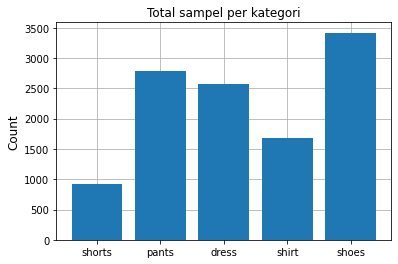

In [11]:
# Buat plot banyak gambar per folder
import matplotlib.pyplot as plt
import numpy as np

folder_count = os.listdir(new_dir)

y_pos = np.arange(len(folder_count))
plt.bar(y_pos, image_count, align='center', zorder=3)
plt.xticks(y_pos, folder_count)
plt.ylabel('Count', fontsize=12)
plt.title('Total sampel per kategori')
plt.grid(zorder=0)
plt.show()

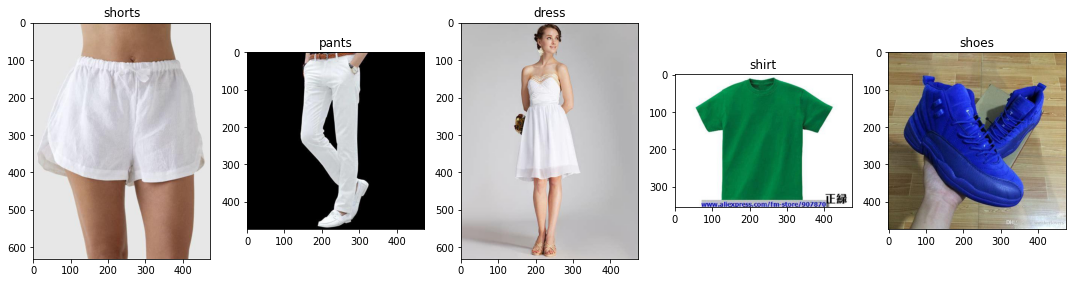

In [12]:
# Tampilkan sampel gambar per folder
import matplotlib.image as mpimg
from random import randint

fig = plt.figure(figsize=(15,5))
axes = []
i = 1
for folder in os.listdir(new_dir):
    axes.append(fig.add_subplot(1, 5, i))
    i += 1
    title=(str(folder))
    axes[-1].set_title(title)
    folder_path = os.path.join(new_dir, folder) 
    rnd_number = randint(0,len(os.listdir(folder_path)))
    img_dir = os.listdir(folder_path)[rnd_number]
    img_dir = os.path.join(folder_path, img_dir) 
    image = mpimg.imread(img_dir)
    plt.imshow(image)
fig.tight_layout()    
plt.show()

In [34]:
# Pisahkan atribut dan label
import cv2 as cv

Image = []  # List gambar
Category = []  # List kategori gambar

for folder in os.listdir(new_dir): 
    folder_path = os.path.join(new_dir, folder)
    for img in os.listdir(folder_path):
        path_to_img = os.path.join(folder_path, img)
        # Konversi gambar
        image = cv.imread(path_to_img)
        image = cv.resize(image, (75,75))
        Image.append(image)
        Category.append(folder)

In [35]:
# Binarisasi label
from sklearn.preprocessing import LabelBinarizer

X_img = np.array(Image)

lb_category = LabelBinarizer()
Y_cat = lb_category.fit_transform(Category)

In [36]:
print('Images:', X_img.shape)
print('Labels:', Y_cat.shape)

Images: (11385, 75, 75, 3)
Labels: (11385, 5)


In [37]:
cat_classes = lb_category.classes_.astype('object')
cat_classes

array(['dress', 'pants', 'shirt', 'shoes', 'shorts'], dtype=object)

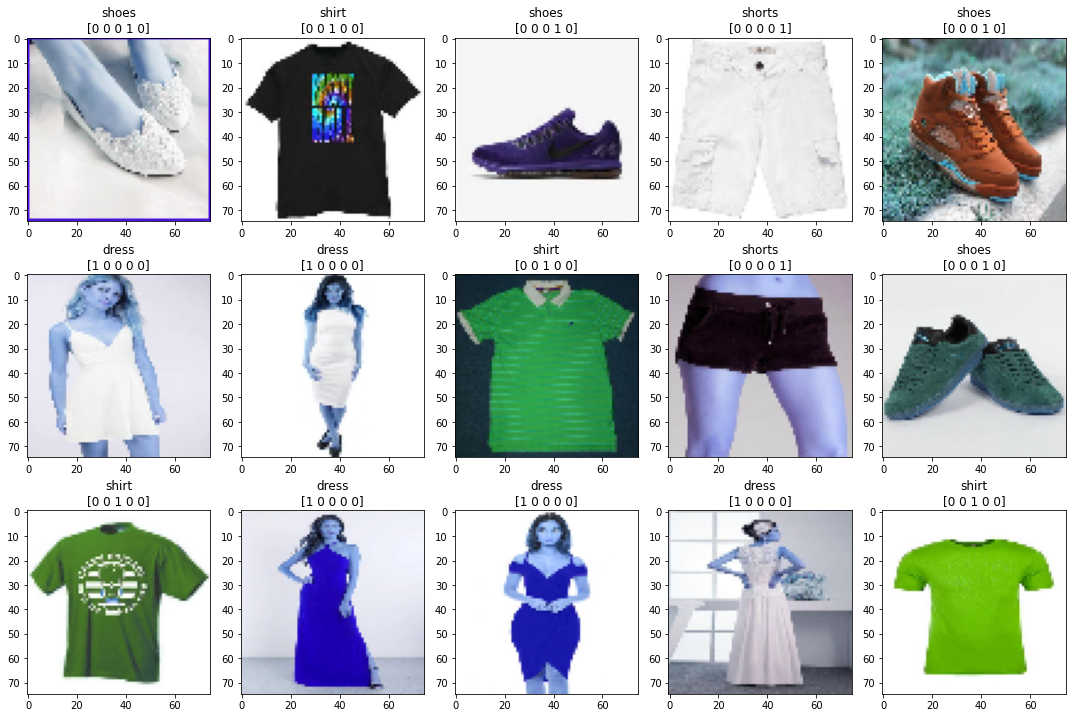

In [38]:
# Plot random gambar
fig = plt.figure(figsize=(15,10))
axes = []
for i in range(15):
    rnd_number = randint(0,len(X_img))
    axes.append(fig.add_subplot(3, 5, i+1))

    bin_class = Y_cat[rnd_number]
    cat_class = cat_classes[np.argmax(Y_cat[rnd_number])]
    title = f'{cat_class}\n{bin_class}'

    axes[-1].set_title(title)  
    plt.imshow(X_img[rnd_number])

fig.tight_layout()    
plt.show()

In [39]:
# Bagi train set dan test set
from sklearn.model_selection import train_test_split

X, X_test, catY, catY_test = train_test_split(X_img, Y_cat, test_size = 0.2)

In [40]:
print(X.shape, catY.shape)
print(X_test.shape, catY_test.shape)

(9108, 75, 75, 3) (9108, 5)
(2277, 75, 75, 3) (2277, 5)


In [41]:
# Augmentasi gambar generator
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

img_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, 
                                 height_shift_range=0.2, width_shift_range=0.2,
                                 zoom_range=0.2, shear_range=0.2,
                                 rotation_range=45, fill_mode='nearest', 
                                 validation_split = 0.2)
                                      
train_gen = img_datagen.flow(X, catY, shuffle=True,)

val_gen = img_datagen.flow(X, catY, subset='validation', shuffle=False)

In [42]:
# Buat arsitektur CNN
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models

model = Models.Sequential([
    Layers.Conv2D(input_shape=(75,75,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    Layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    Layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    Layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    Layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    Layers.Flatten(),
    Layers.Dense(units=1024,activation="relu"),
    Layers.Dropout(0.5),
    Layers.Dense(units=1024,activation="relu"),
    Layers.Dropout(0.5),
    Layers.Dense(units=5, activation="softmax"),                                                  
])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 75, 75, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 18, 256)       295168    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 9, 9, 512)        

In [59]:
# Tentukan optimizer dan loss function model
import tensorflow.keras.optimizers as Optimizer

model.compile(optimizer=Optimizer.Adam(lr=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi model > 92% !!")
      self.model.stop_training = True

callback90 = myCallback()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                                 patience=3, min_lr=1.0e-05, verbose=1)

In [62]:
# Latih model
history = model.fit(train_gen, validation_data=val_gen, 
                    epochs=100, batch_size=32, 
                    callbacks=[callback90, reduce_lr],
                    verbose=1)

Epoch 1/100
285/285 [==============================] - 461s 2s/step - loss: 1.0537 - accuracy: 0.5687 - val_loss: 0.8624 - val_accuracy: 0.6639
Epoch 2/100
285/285 [==============================] - 460s 2s/step - loss: 0.8407 - accuracy: 0.6865 - val_loss: 0.7720 - val_accuracy: 0.7188
Epoch 3/100
285/285 [==============================] - 462s 2s/step - loss: 0.7210 - accuracy: 0.7339 - val_loss: 0.6519 - val_accuracy: 0.7622
Epoch 4/100
285/285 [==============================] - 463s 2s/step - loss: 0.6598 - accuracy: 0.7668 - val_loss: 0.5942 - val_accuracy: 0.7847
Epoch 5/100
285/285 [==============================] - 463s 2s/step - loss: 0.5831 - accuracy: 0.7950 - val_loss: 0.5456 - val_accuracy: 0.8072
Epoch 6/100
285/285 [==============================] - 461s 2s/step - loss: 0.5263 - accuracy: 0.8141 - val_loss: 0.4605 - val_accuracy: 0.8391
Epoch 7/100
285/285 [==============================] - 463s 2s/step - loss: 0.4826 - accuracy: 0.8329 - val_loss: 0.4650 - val_accuracy:

<function matplotlib.pyplot.show>

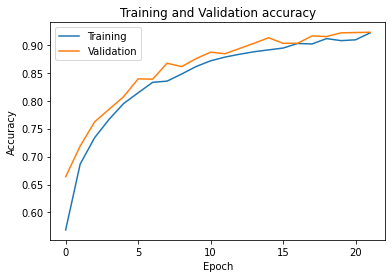

In [63]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show

<function matplotlib.pyplot.show>

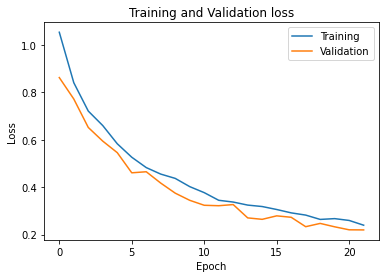

In [64]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show

In [69]:
# Evaluasi model pada test set
score = model.evaluate(X_test, catY_test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

72/72 [==============================] - 26s 361ms/step - loss: 55.9317 - accuracy: 0.8647
Test Loss: 55.93169403076172
Test accuracy: 0.8647342920303345


dress


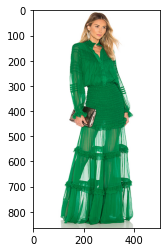

In [115]:
# Prediksi gambar
img_url = "https://is4.revolveassets.com/images/p4/n/d/AXIS-WD346_V1.jpg"
img_path = tf.keras.utils.get_file('dress_img', origin=img_url)

image = mpimg.imread(img_path)
img = cv.resize(img, (75,75))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(cat_classes[np.argmax(score)])
plt.imshow(image)

In [116]:
# Konversi model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model dalam format .tflite
with tf.io.gfile.GFile('model.tflite', 'wb') as model_file:
    model_file.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp186lwqh1/assets


INFO:tensorflow:Assets written to: /tmp/tmp186lwqh1/assets
